# Gromov Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [258]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")


# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# From GDTW example code
import torch
from AligningTimeSeries.Code.GDTW import gromov_dtw 
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from imageio import imread
import sklearn

In [259]:
# Y-position of hand and end-effector tend to be most consistently aligned. Use those to discover the time warp mapping

# Import data from csvs
end_eff_raw = pd.read_csv(r'C:\Users\jmoln\Documents\Projects\NonAnthroHands_User_Study\data\positions\positions_4_data\j2s6s300_end_effectorMotion_10.csv')
end_eff_data = end_eff_raw.to_numpy()
end_eff_pos = (end_eff_data[...,0],end_eff_data[...,2])
#print (end_eff_posX)

hand_raw = pd.read_csv(r'C:\Users\jmoln\Documents\Projects\NonAnthroHands_User_Study\data\positions\positions_4_data\RightHandAnchorMotion_10.csv')
hand_data = hand_raw.to_numpy()
hand_pos = (hand_data[...,0],hand_data[...,2])

x = end_eff_pos
y = hand_pos

Text(0.5, 1.0, 'Euclidean Distance')

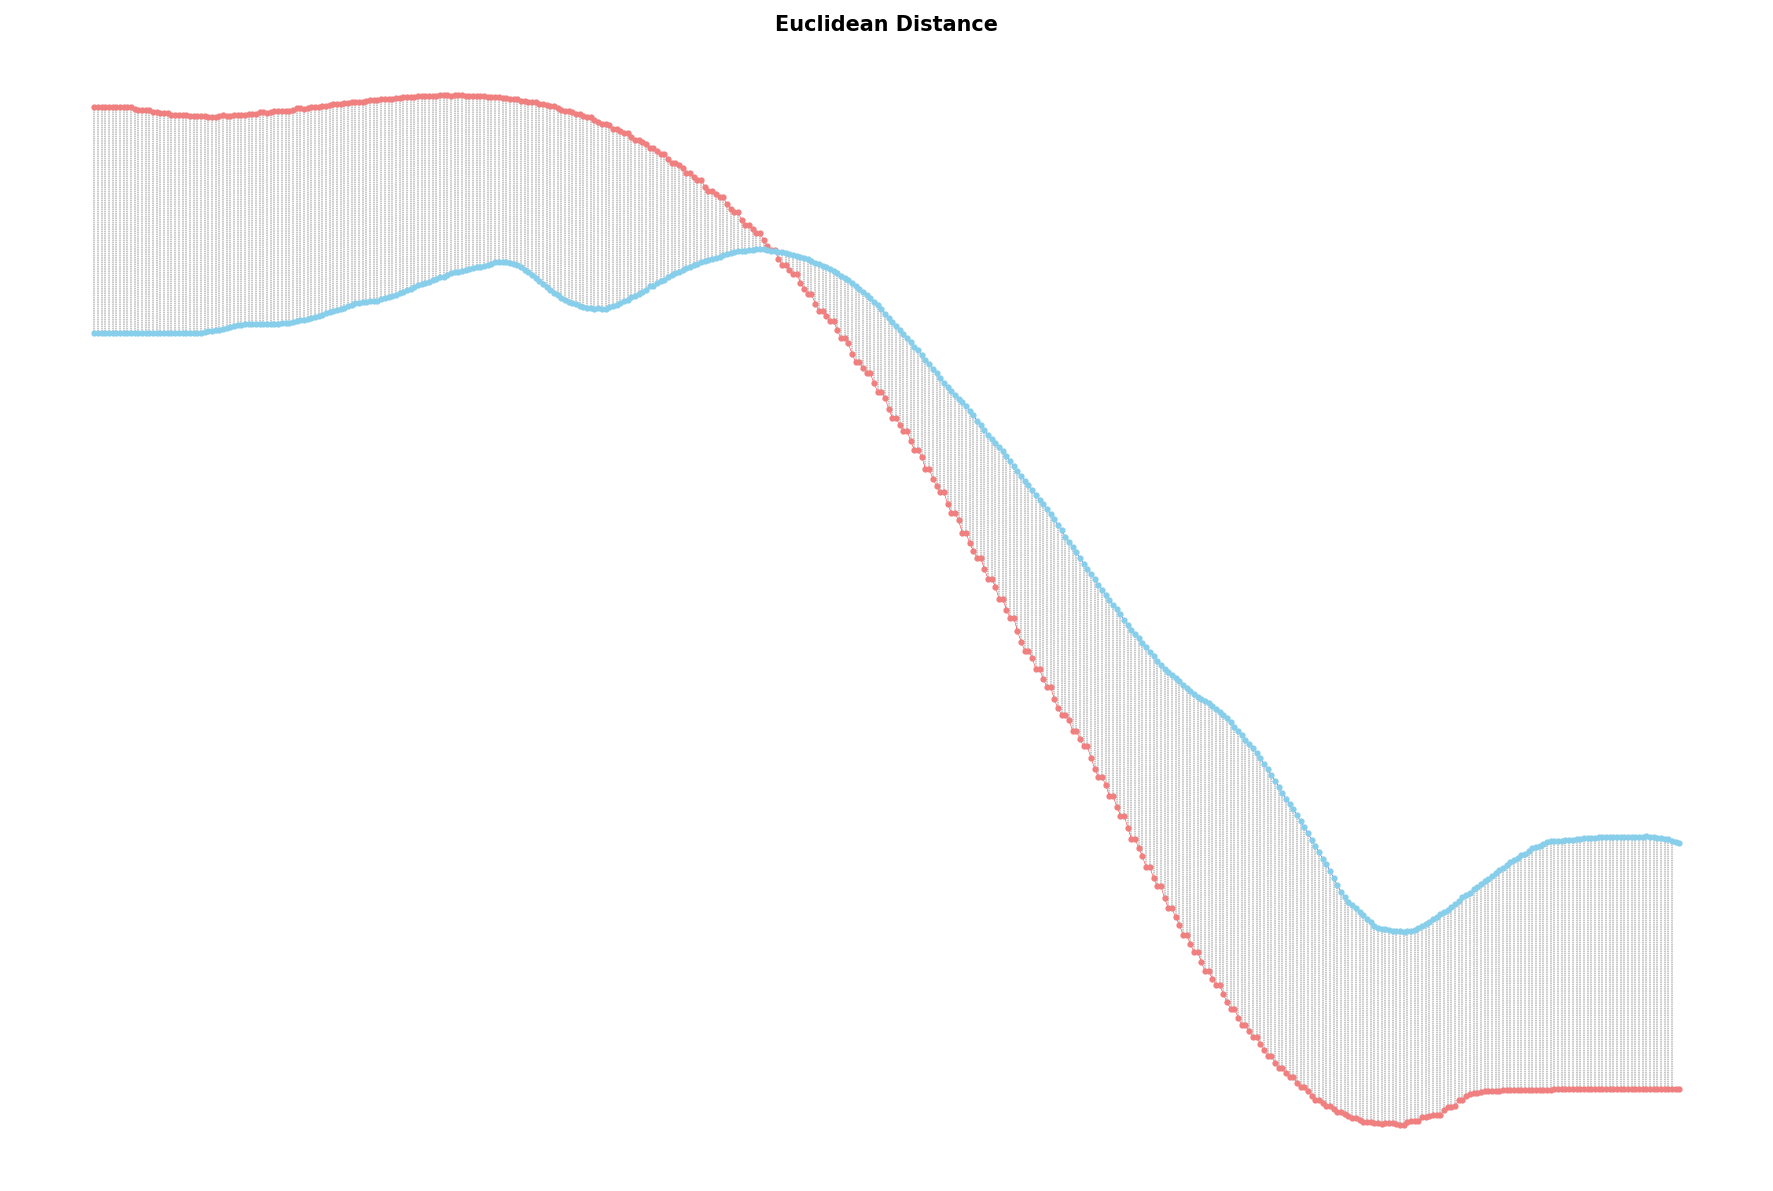

In [253]:
# Show log file data with the Euclidean distance between

fig, ax = plt.subplots(figsize=(15, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

xx = [(i, x[1][i]) for i in np.arange(0, len(x[1]))]
yy = [(j, y[1][j]) for j in np.arange(0, len(y[1]))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=0.2)

ax.plot(x[1], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y[1], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance", fontsize=10, fontweight="bold")

In [254]:
# Conduct traditional DTW with fastdtw, copied from Chauhan's github: https://github.com/nageshsinghc4/-Dynamic-Time-Warping-DTW-
dtw_distance, warp_path = fastdtw(x[1], y[1], dist=euclidean) 

Text(0.5, 1.0, 'DTW Distance')

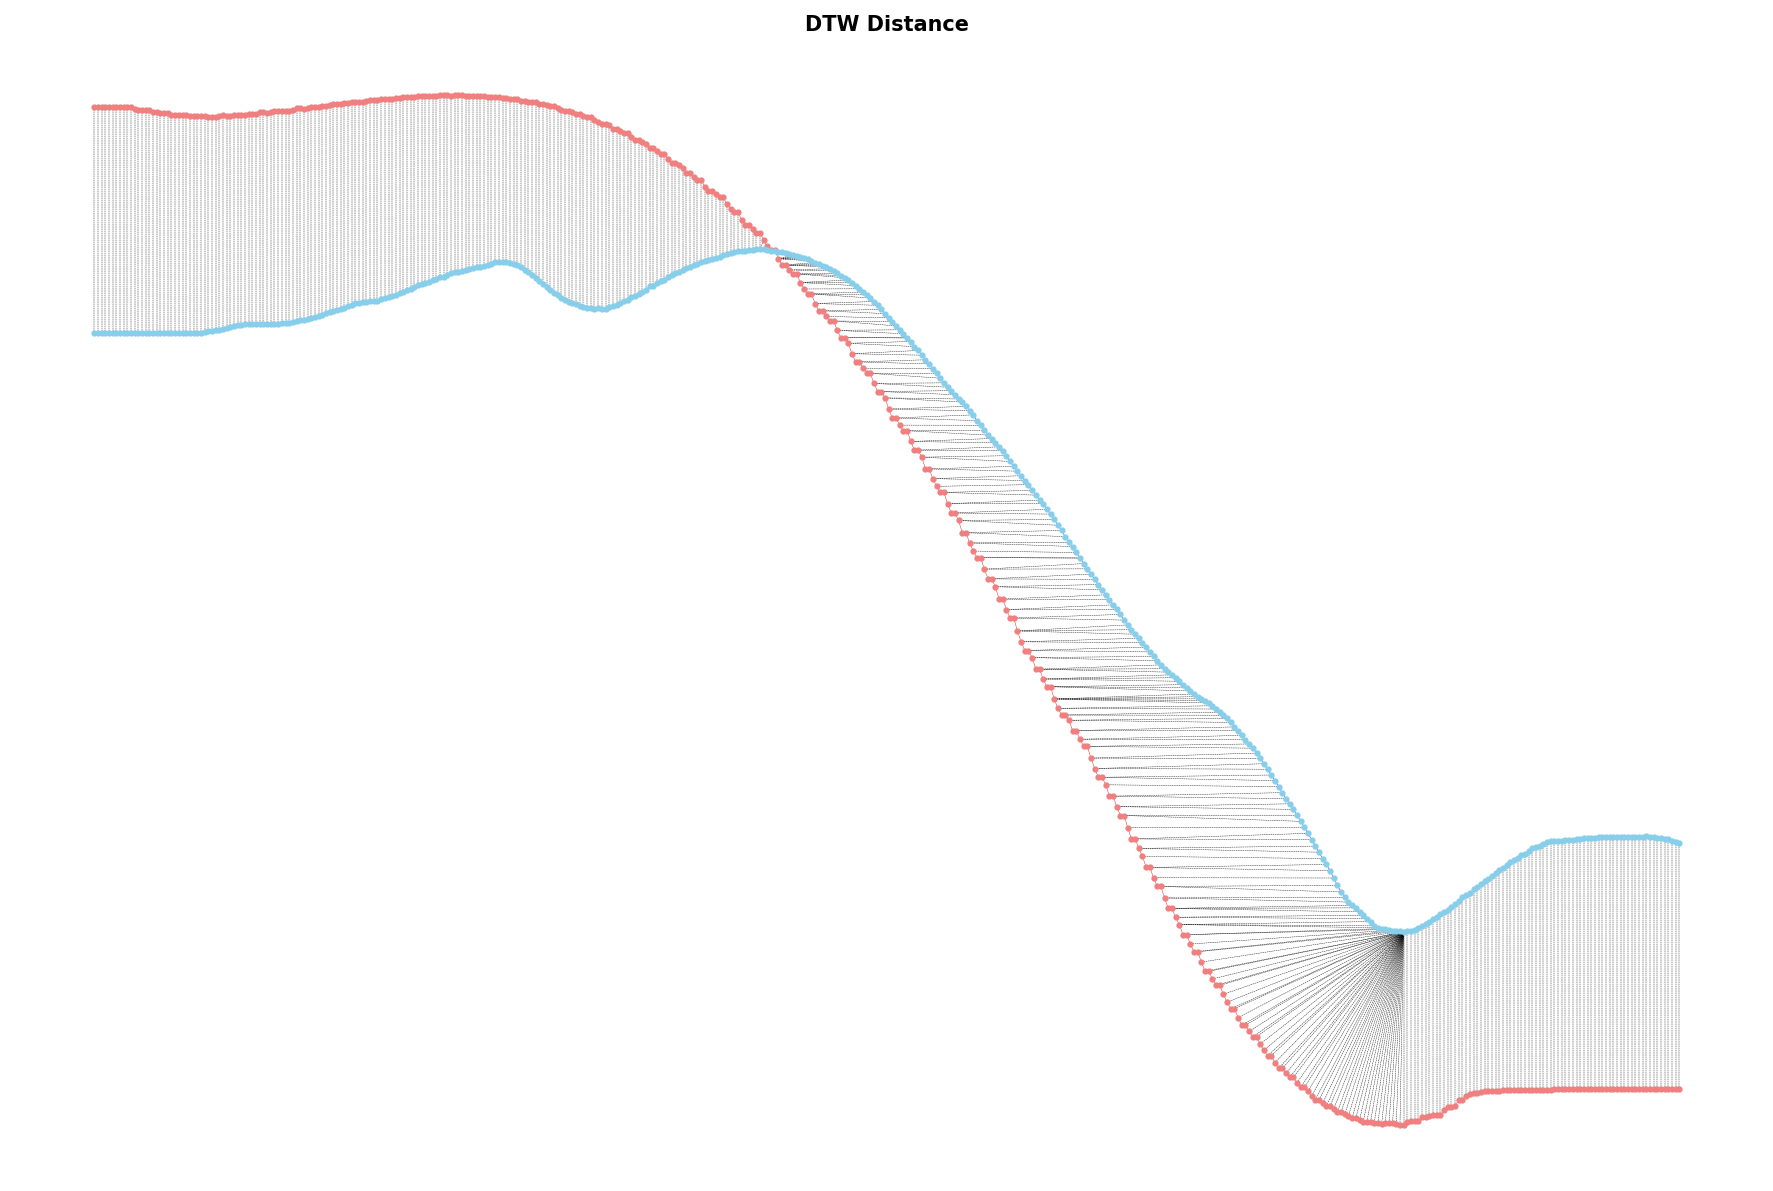

In [255]:
# Show traditional DTW result
fig, ax = plt.subplots(figsize=(15, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x[1][map_x], y[1][map_y]], '--k', linewidth=0.2)

ax.plot(x[1], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y[1], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Distance", fontsize=10, fontweight="bold")

Text(0.5, 1.0, 'Normalized DTW Distance')

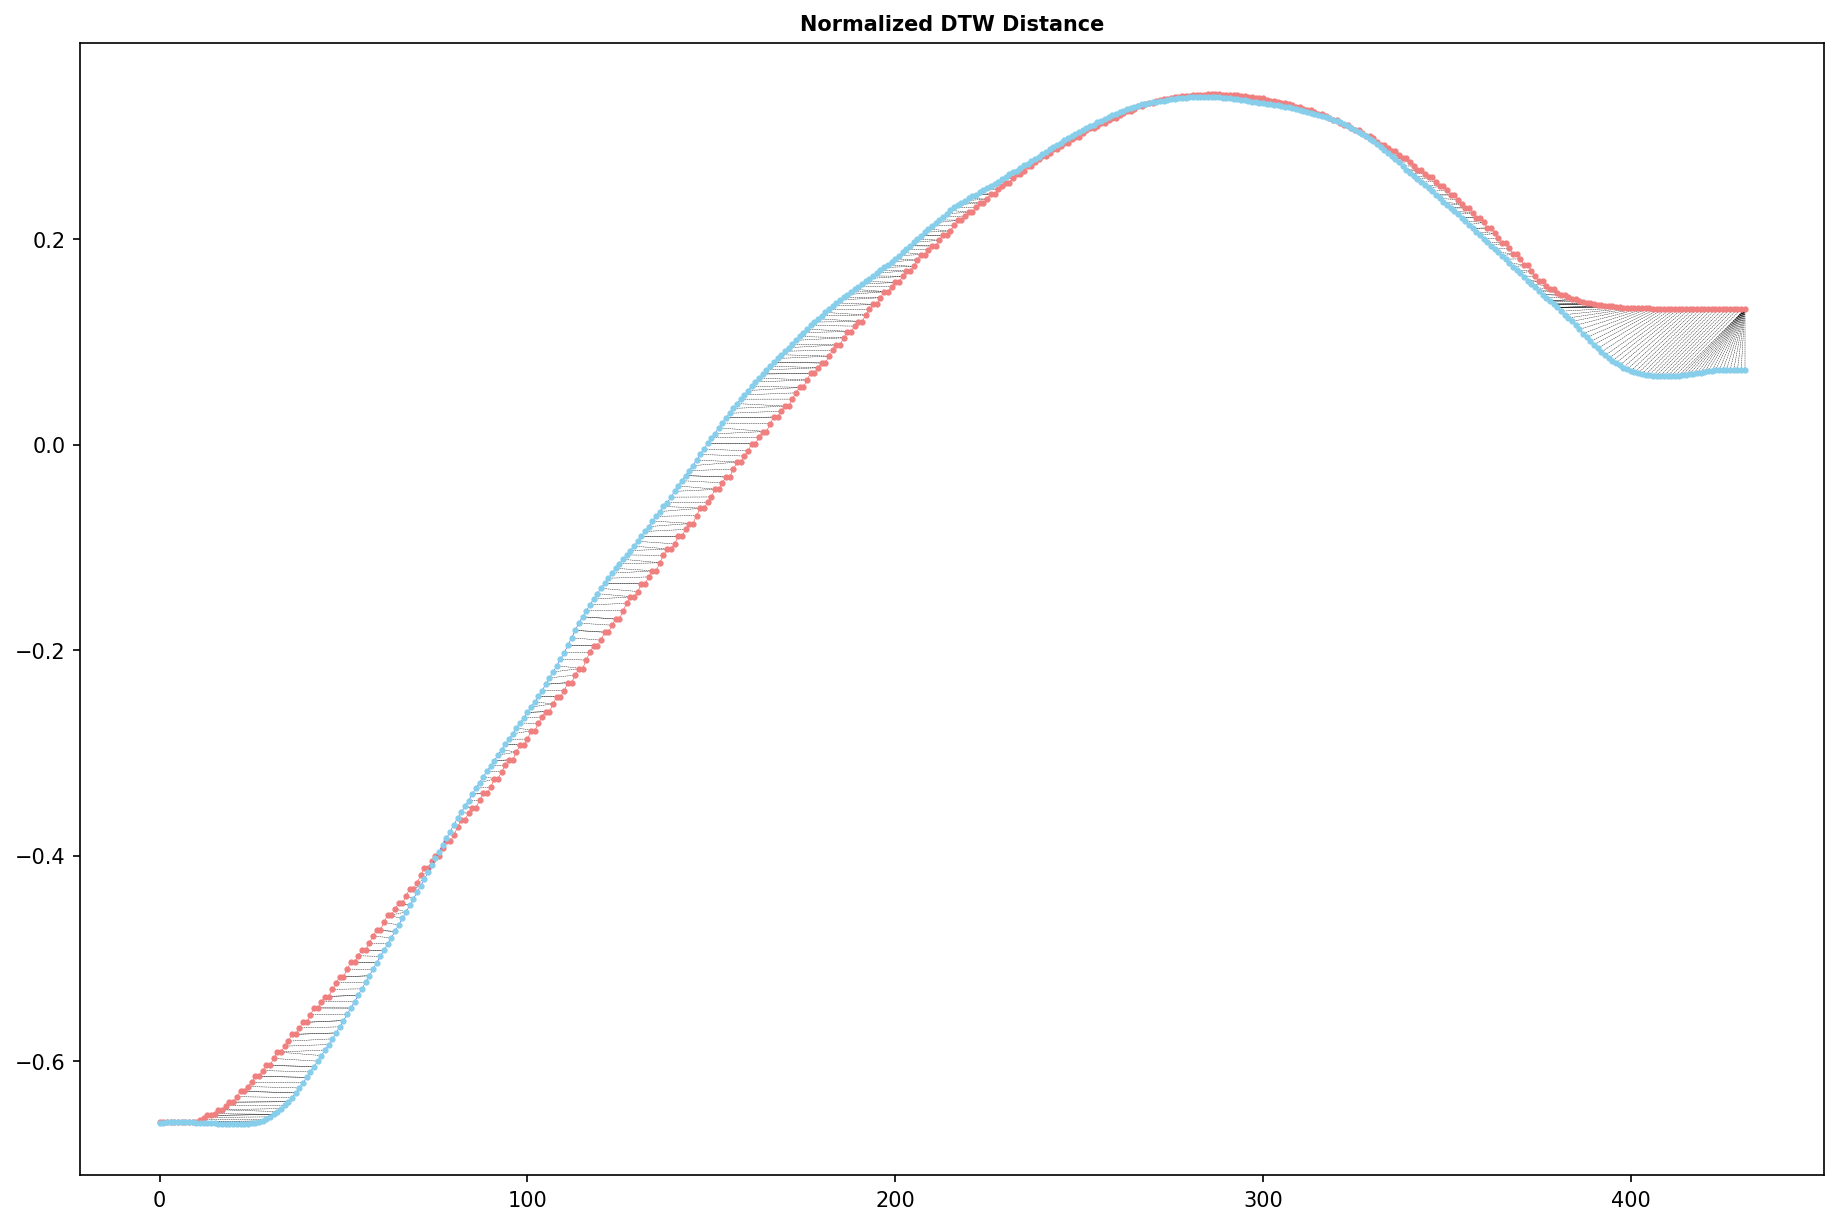

In [260]:
# Normalize x and y to prevent scaling issues from creating DTW misalignment

scale_x = 1/(np.max(x[1])-np.min(x[1]))
scale_y = 1/(np.max(y[1])-np.min(y[1]))

center_x = np.mean(x[1])
center_y = np.mean(y[1])

x_norm = (x[0],(x[1] - center_x)*scale_x)
y_norm = (y[0],(y[1] - center_y)*scale_y)

dtw_distance, warp_path = fastdtw(x_norm[1], y_norm[1], dist=euclidean) 

# Show normalized plots
fig, ax = plt.subplots(figsize=(15, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('on')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x_norm[1][map_x], y_norm[1][map_y]], '--k', linewidth=0.2)

ax.plot(x_norm[1], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y_norm[1], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("Normalized DTW Distance", fontsize=10, fontweight="bold")

In [257]:
# Reshape X/Y data for GDTW operations

x = np.transpose(x)
x = torch.tensor(x)
y = np.transpose(y)
y = torch.tensor(y)

In [208]:
# Find lowest cost path using Gromov-DTW, from the following github: https://github.com/samcohen16/Aligning-Time-Series

#iterations don't matter for GDTW, only for soft-GDTW. I think?
GDTW = gromov_dtw(max_iter=5,gamma=0.1,loss_only=0,dtw_approach='GDTW',verbose=1) 
loss, A = GDTW(x,y)

iter: 0 GDTW: 9926.1044921875
iter: 1 GDTW: 4535.95703125
iter: 2 GDTW: 2784.5771484375
iter: 3 GDTW: 1861.6533203125
iter: 4 GDTW: 1486.494140625


In [213]:
A

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [214]:
loss.item()

242.677734375

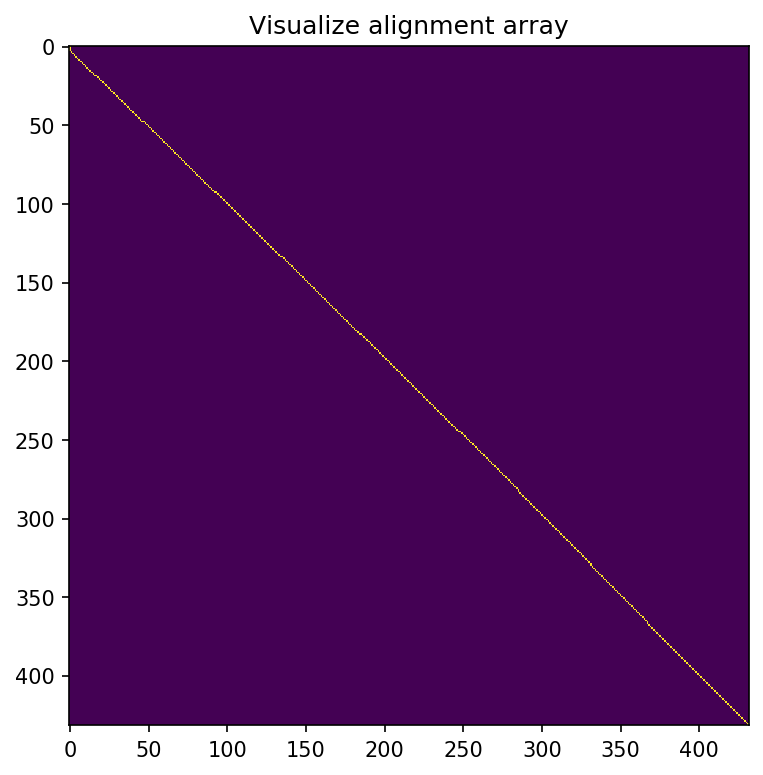

In [209]:
fig = plt.figure(figsize=(8,6))
plt.imshow(A)
plt.title("Visualize alignment array")
plt.show()

Text(0.5, 1.0, 'DTW Distance')

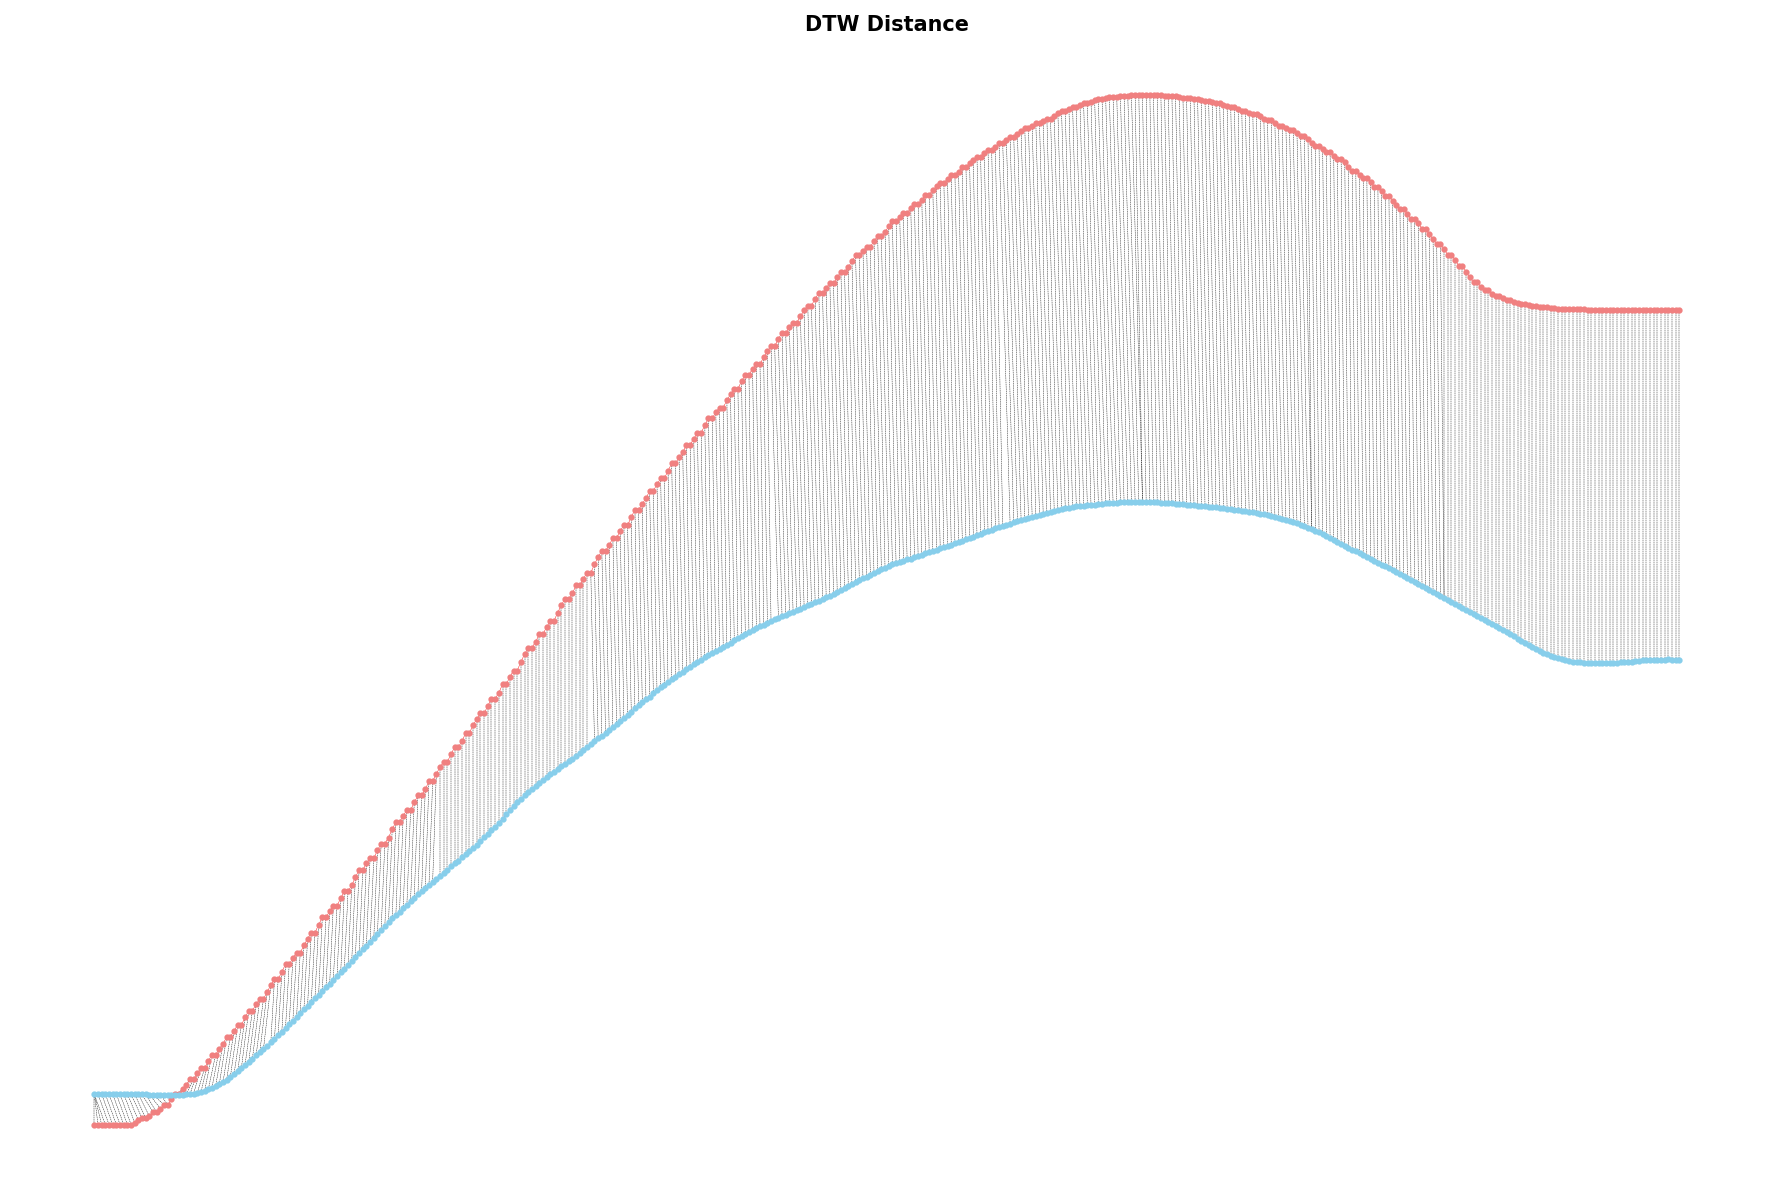

In [210]:
# Grab indices from alignment array A
len_x = x.size()[0]
len_y = y.size()[0]

path = []
for i in range (len_x):
    tempval = (A[i] == 1.0).nonzero(as_tuple=True)[0][0].item()
    path.append((i, tempval))

# Then show Gromov-DTW result
fig, ax = plt.subplots(figsize=(15, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in path:
    ax.plot([map_x, map_y],[x[map_x][1], y[map_y][1]], '--k', linewidth=0.2)

ax.plot(x[...,1], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y[...,1], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Distance", fontsize=10, fontweight="bold")

In [211]:
# Normalized GDTW
x = np.transpose(x_norm)
x = torch.tensor(x)
y = np.transpose(y_norm)
y = torch.tensor(y)

iter: 0 GDTW: 319.6396484375
iter: 1 GDTW: 243.650390625
iter: 2 GDTW: 242.677734375
iter: 3 GDTW: 242.6767578125


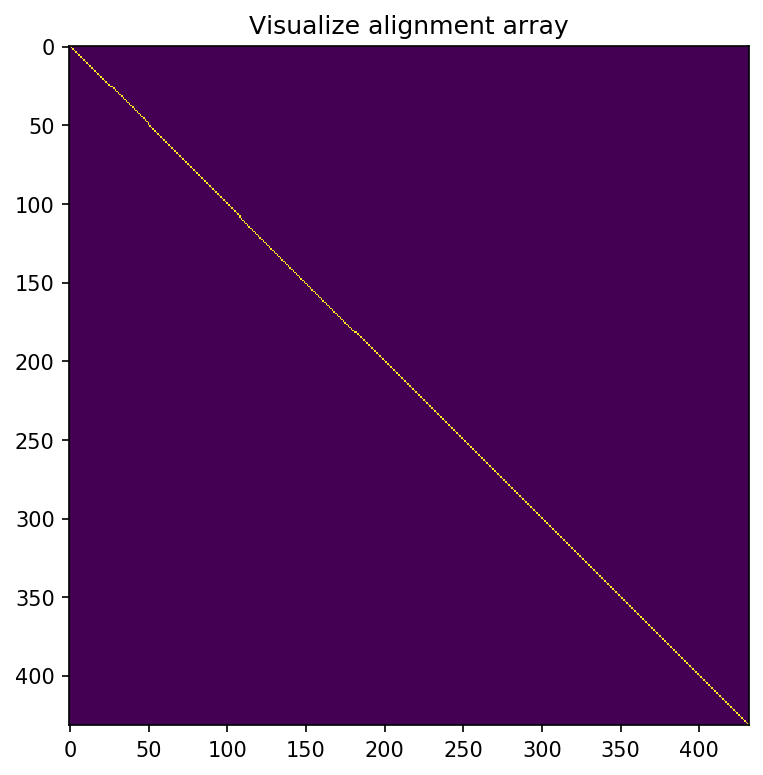

Text(0.5, 1.0, 'DTW Distance')

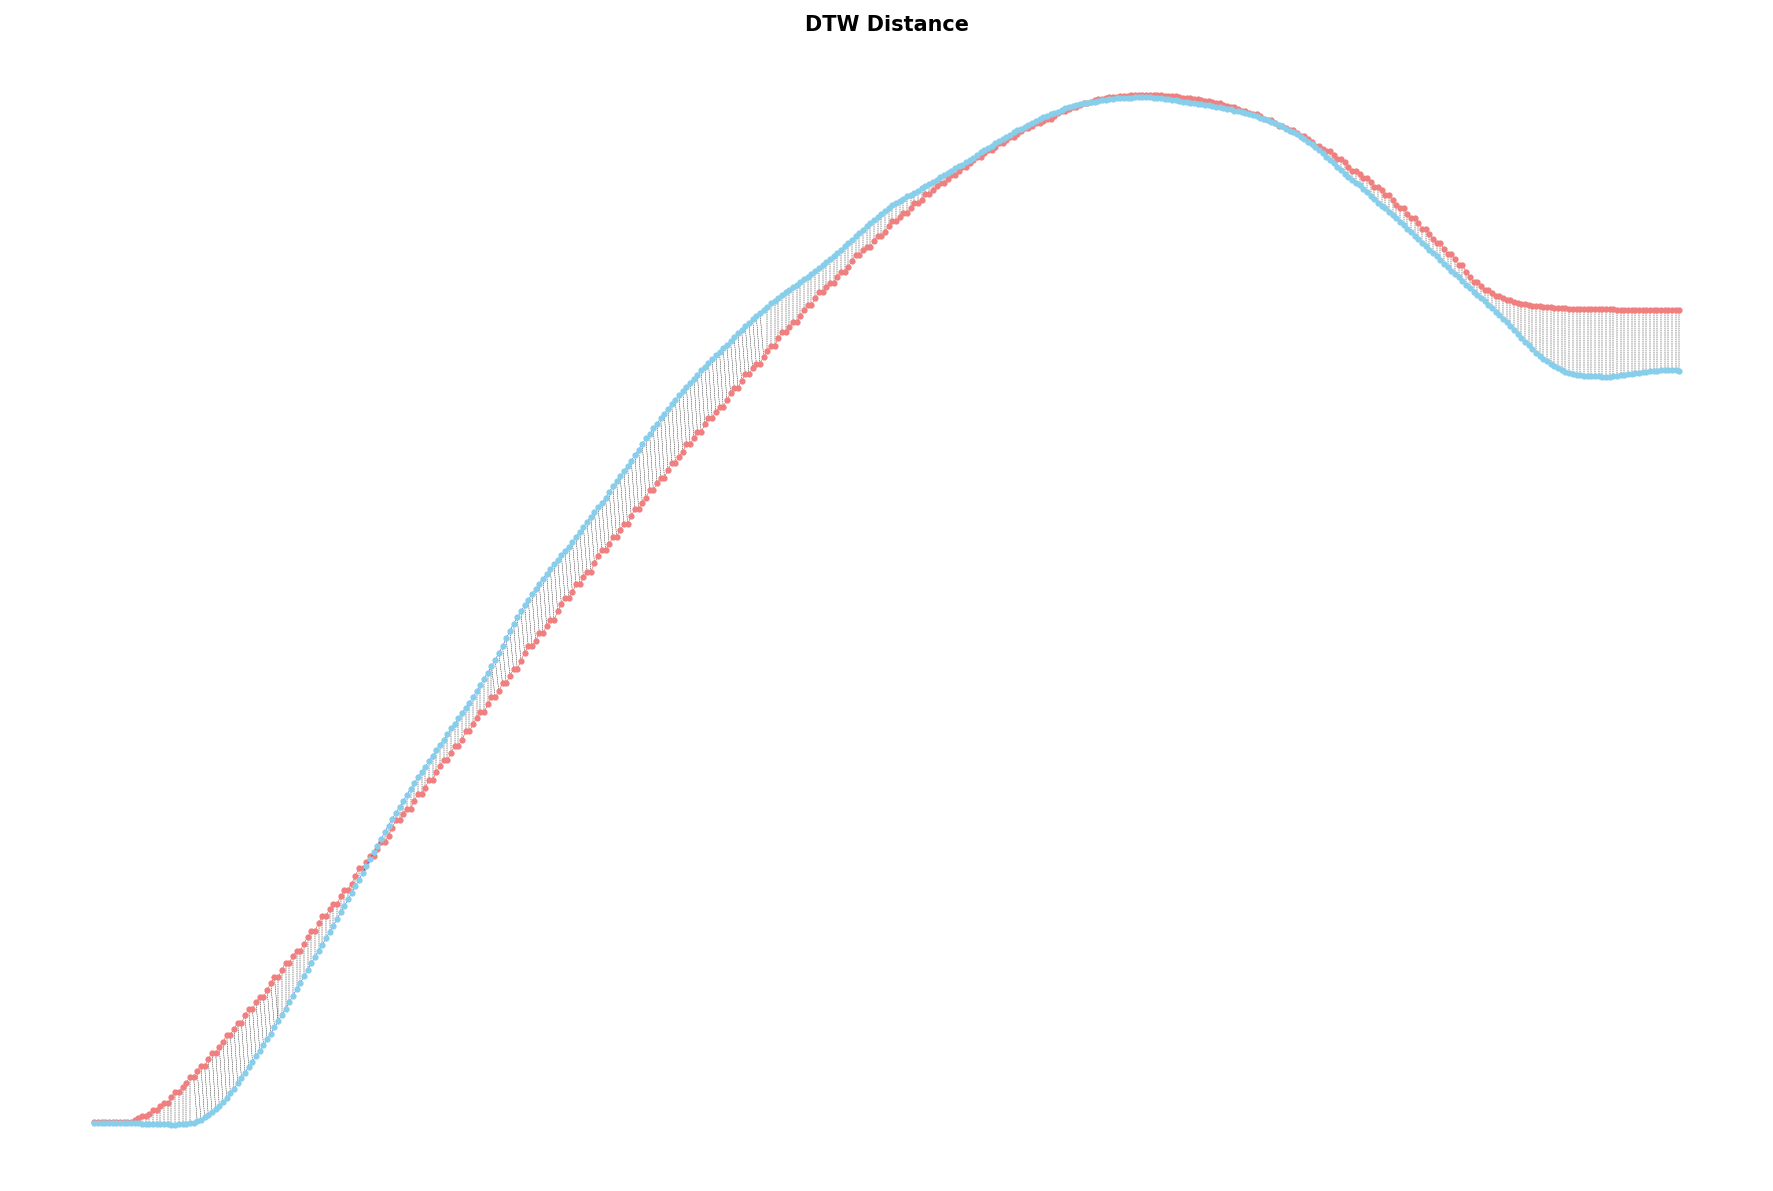

In [212]:
GDTW = gromov_dtw(max_iter=5,gamma=0.1,loss_only=0,dtw_approach='GDTW',verbose=1) 
loss, A = GDTW(x,y)

fig = plt.figure(figsize=(8,6))
plt.imshow(A)
plt.title("Visualize alignment array")
plt.show()

# Grab indices from alignment array A
len_x = x.size()[0]
len_y = y.size()[0]

path = []
for i in range (len_x):
    tempval = (A[i] == 1.0).nonzero(as_tuple=True)[0][0].item()
    path.append((i, tempval))

# Then show Gromov-DTW result
fig, ax = plt.subplots(figsize=(15, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in path:
    ax.plot([map_x, map_y],[x[map_x][1], y[map_y][1]], '--k', linewidth=0.2)

ax.plot(x[...,1], '-ro', label='x', linewidth=0.2, markersize=2, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y[...,1], '-bo', label='y', linewidth=0.2, markersize=2, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Distance", fontsize=10, fontweight="bold")